# Hill Climbing Method

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
from collections import deque

import gym

In [2]:
plt.style.use('ggplot')

## Set Configs

In [3]:
GAMMA = 1.0
PRINT_EVERY = 100
NOISE_SCALE = 1e-2

## Set Environment

In [4]:
ENV_NAME = 'CartPole-v0'
env = gym.make(ENV_NAME).unwrapped; env.seed(90);

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [5]:
print('Environment Display:')
env.reset() # reset environment to a new, random state
env.render()

print('State space {}'.format(env.observation_space))
print('Action space {}'.format(env.action_space))

Environment Display:
State space Box(4,)
Action space Discrete(2)


## Define The Policy

In [6]:
class Policy():
    """Define linear Policy."""
    
    def __init__(self, env):
        
        super(Policy, self).__init__()
        
        state_size = env.observation_space.shape[0]
        action_size = env.action_space.n
        
        self.state_size = state_size
        self.action_size = action_size
        # init weights for simple linear policy: state space by action space
        self.weights = 1e-4 * np.random.rand(state_size, action_size)
        
    def act(self, state):
        
        probs = self.forward(state)
        action = np.argmax(probs) # deterministic policy
        # action = np.random.choice(self.action_size, p=probs) # if stochastic policy
        
        return action
    
    def save(self, policy_path):
        
        if not os.path.exists('../agents/'): os.makedirs('../agents/')
        with open(policy_path, 'wb') as weights:
            pickle.dump(self.weights, weights)
            
    def forward(self, state):
        
        x = np.dot(state, self.weights)
        x = np.exp(x)/ sum(np.exp(x))
        
        return x

In [7]:
policy = Policy(env)

## Train The Agent

In [8]:
def train_agent(num_episodes, max_time=1000, gamma=1.0, noise_scale=1e-2):
    """Train agent using hill climbing algorithm with adaptive noise scaling."""
    
    scores = []
    scores_window = deque(maxlen=100)
    
    R_best = -np.inf
    w_best = policy.weights
    
    for i_episode in range(1, num_episodes+1):
        
        state = env.reset()
        rewards = []        
        for time in range(max_time):
            
            action = policy.act(state)
            next_state, reward, done, _ = env.step(action)
            
            state = next_state
            rewards.append(reward)
            if done:
                break
                
        scores_window.append(sum(rewards))
        scores.append(sum(rewards))
        
        discounts = [gamma**i for i in range(len(rewards)+1)]
        R = sum([a*b for a,b in zip(discounts, rewards)])
        
        if R >= R_best: # found better weights
            R_best = R
            w_best = policy.weights
            noise_scale = max(1e-3, noise_scale/ 2)
            policy.weights += noise_scale * np.random.rand(*policy.weights.shape)
        else:
            noise_scale = min(2, noise_scale * 2)
            policy.weights = w_best + noise_scale * np.random.rand(*policy.weights.shape)
            
        print(f'\rEpisode: {i_episode}, Average Score: {np.mean(scores_window):.2f}', end='')
        
        if i_episode % PRINT_EVERY == 0:
            print(f'\rEpisode: {i_episode}, Average Score: {np.mean(scores_window):.2f}')
        if np.mean(scores_window)>=800.0:
            print(f'\nEnvironment solved in {i_episode-100:d} episodes! Average Score: {np.mean(scores_window):.2f}')
            policy.weights = w_best
            policy.save(f'../agents/HC_{ENV_NAME}.pth')
            break
            
    policy.save(f'../agents/HC_{ENV_NAME}.pth')
    print('Training completed.')
    
    return scores

In [9]:
scores = train_agent(num_episodes=1000, max_time=1000)

Episode: 100, Average Score: 117.29
Episode: 176, Average Score: 802.06
Environment solved in 76 episodes! Average Score: 802.06
Training completed.


## Evaluate The Agent

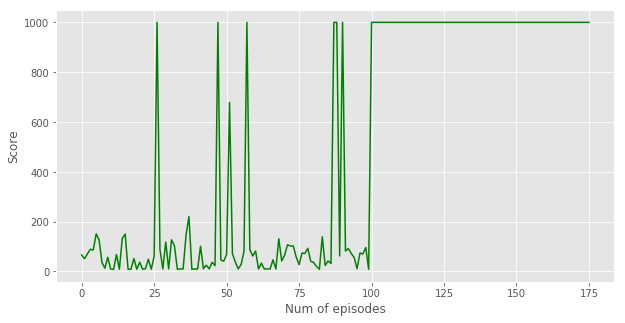

In [10]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(scores)), scores, color='green')
plt.xlabel('Num of episodes')
plt.ylabel('Score')
if not os.path.exists('../images/'): os.makedirs('../images/')
plt.savefig('../images/plot_of_hill_climbing_policy_evaluation.png')
plt.show()

## 🎬 Watch The Smart Agent

In [11]:
num_episodes = 5

for i_episode in range(1, num_episodes+1):
    
    state = env.reset()
    rewards = []
    for time_step in range(1000):
        
        env.render() # render the screen
        
        action = policy.act(state) # select an action
        next_state, reward, done, _ = env.step(action)
        
        state = next_state
        rewards.append(reward)
        if done:
            break
            
    print(f'\rEpisode: {i_episode}, Average Score: {sum(rewards):.2f}')

env.close()

Episode: 1, Average Score: 1000.00
Episode: 2, Average Score: 1000.00
Episode: 3, Average Score: 1000.00
Episode: 4, Average Score: 1000.00
Episode: 5, Average Score: 1000.00


---